# Emcee multifit
17 November 2019

Now that we've shown that `emcee` can fit a single subhalo or interloper pretty well (as an effective subhalo), let's see if we can handle multiple interlopers. For now, the multiple interlopers will all be at the same redshift.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee

from multiprocessing import Pool

# Generate original image

In [2]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cms
#%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import copy

import pickle

In [3]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return (con*m_msun)/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    ## takes in physical coordinates (Mpc), identifies the appropriate pixel number
    return (xi_to_x(xi,z))/pixsize + pixnum/2.
def inv_rs_angle(zd,rs_angle):
    ## takes in the rs angle in arcsec gives rs in in MPC
    Dd = ADD(0,zd)
    return 4.848e-6*Dd*rs_angle


def inv_alpha_s(alpha_s,rs,zd,zs):
    ## takes in subhalo angular deflection at scale radius, scale radius,
    ## interloper redshift and source redshift and returns interloper mass
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return (alpha_s/con)*((rs_mpc**2.)*sigma_cr(zd,zs))

**Image-generation parameters**

From some initial testing, it seems that if we generate interlopers close to the Einstein ring, then we can constrain the parameters much better (otherwise, there is a lot of degeneracy).

In [322]:
# np.random.seed(334) for N=1, j=50, generate subhalo very close to Einstein ring (limits for variables are not necessary)
np.random.seed(333)

## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)
beta_ras, beta_decs = [1.7],[0.3]#this is the source position on the source plane

n_sersic_source = 1.5

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 1/3.
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

n_sersic_source_clumps = 1.5

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 1 ##Number of perturbers
M = 1 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
# Perturbers are uniformly distributed within a disk of radius `disc_size * r_theta_lens`
#r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
# let's cheat to make this more interesting (TODO: change this back)
r2s = (r_theta_lens**2.)*np.random.uniform(.9,1.1,size=(N,M))


rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M]) # will add pixel values in the next cell
ypixs = np.zeros([Nit,N,M]) #
####################################################################################################

## Specific image $-$ choose `j`, `k`
Note that we'll be choosing one specific redshift and one specific statistic for now.

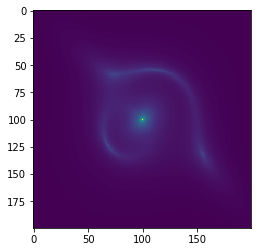

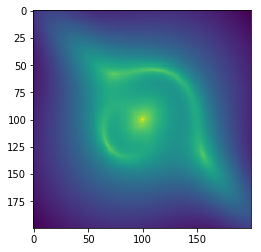

In [323]:
#j = 19 # arbitrary choice (loop over redshifts) (19 is where zd \approx zl)
zd = zl
k = 0 # also arbitrary choice (loop over statistics)

beta_ra, beta_dec = beta_ras[0], beta_decs[0]

xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

m =1.0e7 # mass of interlopers
if j == 0:
    m = 0. # so that the first image will be pure (no interloper effect)
zs = 1.
#zd = zds[j] # interloper redshift
rs = 0.001  # interloper scale radius r_s
A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE

kext = float(k_ext(N,m,A,zl,zs,pixsize))
rsang = float(rs_angle(zd,rs))
alphars = float(alpha_s(m,rs,zd,zs))

## Setting lens_model_list and redshift_list
lens_model_main = ['SPEP']
lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
redshift_main = [zl]
redshift_interlopers = [zd]+[zd for i in range(N)]
# (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
if zl >= zd:
    lens_model_list = lens_model_interlopers + lens_model_main
    redshift_list = redshift_interlopers + redshift_main
else:
    lens_model_list = lens_model_main + lens_model_interlopers
    redshift_list = redshift_main + redshift_interlopers


z_source = zs

lensModel_mp = LensModel(lens_model_list=lens_model_list,
                         z_source=z_source,
                         lens_redshift_list=redshift_list, 
                         multi_plane=True)

kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
               'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
kwargs_conv ={'kappa_ext': kext}

### NFW kwargs for the interlopers
kwargs_main_lens = [kwargs_spep]
kwargs_interlopers = [kwargs_conv] # (+ will append interlopers)
for i in range(N):
    center_nfw_x = xi_to_x(xs[i,k],zd)
    center_nfw_y = xi_to_x(ys[i,k],zd)

    kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
    kwargs_interlopers.append(kwargs_nfw)

# (again, need to sort by redshift)
if zl >= zd:
    kwargs_lens = kwargs_interlopers + kwargs_main_lens
else:
    kwargs_lens = kwargs_main_lens + kwargs_interlopers

########################################################################
# set up the list of light models to be used #

# SOURCE light
source_light_model_list = ['SERSIC_ELLIPSE']
for i in range(N_clump):
    source_light_model_list.append('SERSIC')

lightModel_source = LightModel(light_model_list = source_light_model_list)

# LENS light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list = lens_light_model_list)

# SOURCE light kwargs
kwargs_light_source = [{'amp': 1000., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                      'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
for i in range(N_clump):
    kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps,
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})

# LENS light kwargs
kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                      'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

# evaluate surface brightness at a specific position #
#flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel correspon
kernel = psf.kernel_point_source

####################################################################################

# import the ImageModel class #

# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image); plt.show()
plt.imshow(np.log(image)); plt.show()

In principle, we would make the image noisy here, but we'll skip that step for now.

# Define fit model

In [324]:
#print('zl >= zd', zl >= zd)

#N = 2 # number of subhalos to fit to
print(N)
print('zd', zd)

1
zd 0.2


In [325]:
# assume 1 interloper/subhalo for now
lens_model_fit_list = ['SPEP']+['NFW']*N if zl < zd else ['NFW']*N+['SPEP']
lens_model_fit = LensModel(lens_model_list=lens_model_fit_list,
                         z_source=z_source, multi_plane=False)
image_model_fit = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens_model_fit,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)

def gen_image_fit(kwargs_lens_model): # rewrite the cell above as a function of the lens kwargs
    image = image_model_fit.image(kwargs_lens=kwargs_lens_model, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)
    return image

def error(image1, image2):
    assert(image1.shape == image2.shape)
    
    diffsq = (image1 - image2).flatten()**2
    
#     skipidx = 20100 # todo maybe undo this
#     return np.sum(diffsq[:skipidx]) + np.sum(diffsq[skipidx+1:])
    return np.sum(diffsq)

def args_to_img(args):
    assert(len(args) == 2*N+2)
    rsang = args[0]
    alphars = args[1]
    xs = args[2:N+2]
    ys = args[N+2:]
    
    my_spep = kwargs_spep
    my_nfw_list = []
    for i in range(N):
        my_nfw = {'Rs': rsang, 'alpha_Rs': alphars,
                  'center_x': xs[i], 'center_y': ys[i]}
        my_nfw_list.append(my_nfw)

    image_macro = gen_image_fit([my_spep]+my_nfw_list if zl < zd else my_nfw_list+[my_spep])
    return image_macro

def in_limits(args):
    xs = args[2:N+2]
    ys = args[N+2:]
    pos_lim = 300 #np.inf
    
    if args[0] < 0 or args[1] < 0: return False
    elif np.any(abs(xs) > pos_lim) or np.any(abs(ys) > pos_lim): return False
    elif args[0] > 2: return False # TODO: figure out what reasonable limits are
    elif args[1] > .01: return False # TODO: ditto
    else: return True

def log_prob(args):
    if not in_limits(args):
        return -np.inf
    else:
        err = error(image, args_to_img(args))
    return -err #note: can make walkers go closer to the optimum by multiplying the err function

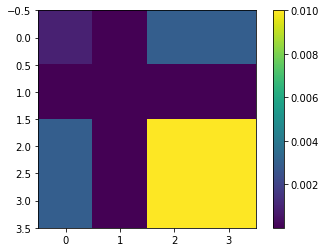

In [326]:
keys = ['rsang', 'alphars'] + ['center_x']*N + ['center_y']*N

ndim = len(keys)

means = [rsang, alphars]+[0]*(2*N)
#means = [rsang,alphars,15,-8,2,15]

randomness = 0
cov = 0.5 - randomness * np.random.rand(ndim**2).reshape((ndim,ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

for i in range(ndim):
    for j in range(ndim):
        keys_ij = [keys[i], keys[j]]
        
        ratio = 1
        for key in keys_ij:
            if key == 'rsang':
                ratio *= .03
            elif key == 'alphars':
                ratio *= .00003
            else:
                ratio *= .1
        cov[i,j] *= ratio

plt.imshow(cov); plt.colorbar(); plt.show()

In [327]:
nwalkers = 40
p0 = means + np.sqrt(np.diag(cov)) * (np.random.rand(nwalkers, ndim)-.5)

In [329]:
%%time
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    state = sampler.run_mcmc(p0, 100, progress=True)

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]

CPU times: user 1.14 s, sys: 212 ms, total: 1.35 s
Wall time: 24.5 s


In [ ]:
%%time
with Pool() as pool:
    new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[], pool=pool)
    state2 = new_sampler.run_mcmc(state, 200)
sampler = new_sampler

In [ ]:
%%time
with Pool() as pool:
    new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[], pool=pool)
    state3 = new_sampler.run_mcmc(state2, 200)
sampler = new_sampler

In [ ]:
%%time
with Pool() as pool:
    new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[], pool=pool)
    state4 = new_sampler.run_mcmc(state3, 2000)
sampler = new_sampler

key rsang


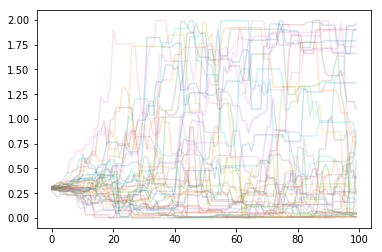

key alphars


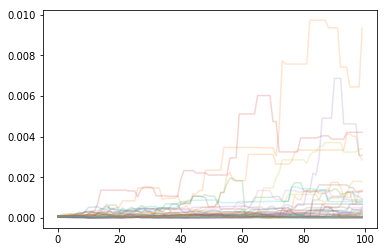

key center_x


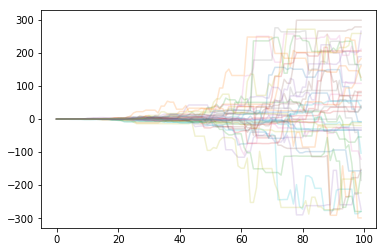

key center_y


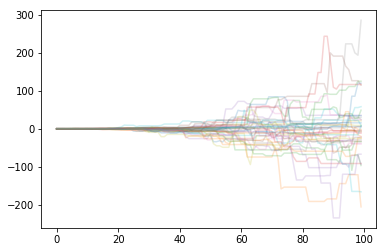

In [330]:
for i, key in enumerate(keys):
    print('key', key)
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i], alpha = .2)
    #plt.ylim(-50,50)
    plt.show()

log mass of each interloper (Msun)


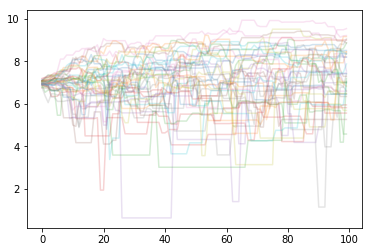

In [331]:
print('log mass of each interloper (Msun)')
for j in range(nwalkers):
    rsang_list = sampler.chain[j,:,0]
    alphars_list = sampler.chain[j,:,1]

    rs_list = inv_rs_angle(zd, rsang_list).to(u.Mpc).value
    mass_list = inv_alpha_s(alphars_list, rs_list, zd, zs).to(u.M_sun)
    logmass_list = np.log10(mass_list.value)

    plt.plot(logmass_list, alpha = .2)

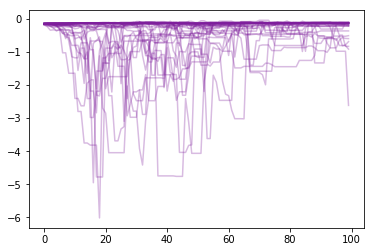

In [332]:
for j in range(nwalkers):
    plt.plot(sampler.lnprobability[j,:], alpha=.3, color='xkcd:purple')
    
#plt.ylim(-5,0)

In [333]:
## Show distribution of last log probs ##

# last_lprobs = sampler.lnprobability[:,-1]
# print(sorted(last_lprobs))

In [334]:
## Calculate covariance matrix for our sample ##

# xs = sampler.chain[:,:,0].flatten()
# vars_data = [sampler.chain[:,:,i].flatten() for i in range(ndim)]
# sample_cov = np.cov(np.vstack(vars_data))
# plt.imshow(np.log(abs(sample_cov))); plt.colorbar()

Compared to TRUE
after, error= 0.14807143619434968


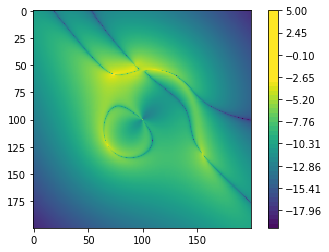

after, error= 2.6158749273311925


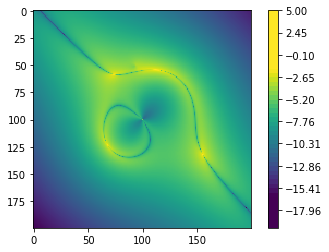

In [335]:
boundaries = np.linspace(-20,5,50)

## "Residuals" compared to true image

print('Compared to TRUE')

for j in range(nwalkers)[:2]:
#     print('before')
#     plt.imshow(args_to_img(sampler.chain[j,0,:])); plt.colorbar(); plt.show()
#     print('after')
#     plt.imshow(args_to_img(sampler.chain[j,-1,:])); plt.colorbar(); plt.show()
#     print('before, error=',error(args_to_img(sampler.chain[j,0,:]),image))
#     plt.imshow(np.log(abs(args_to_img(sampler.chain[j,0,:])-image))); plt.colorbar(boundaries=boundaries); plt.show()
    print('after, error=',error(args_to_img(sampler.chain[j,-1,:]),image))
    plt.imshow(np.log(abs(args_to_img(sampler.chain[j,-1,:])-image))); plt.colorbar(boundaries=boundaries); plt.show()

NOSUB vs. TRUE
null args [0.303784985137773, 0, array(-1.32440902), array(-9.95548906)]
null error 0.12835548072385453


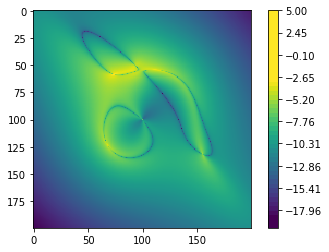

In [336]:
# no subhalos
print('NOSUB vs. TRUE')
nfw_idx = 2 if zl < zd else 1
nosub_args = [rsang, 0]+[kwargs_lens[nfw_idx+i]['center_x'] for i in range(N)]+[kwargs_lens[nfw_idx+i]['center_y'] for i in range(N)]
print('null args', nosub_args)
nosub_img = args_to_img(nosub_args)
print('null error', error(nosub_img, image))
plt.imshow(np.log(abs(nosub_img - image))); plt.colorbar(boundaries=boundaries); plt.show()

Compared to NOSUB
after, error= 0.14807143619434968


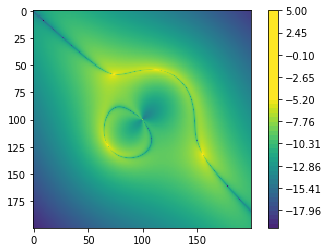

after, error= 2.6158749273311925


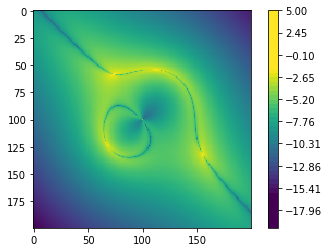

In [337]:
## "Residuals" compared to no-subhalos image ##
print('Compared to NOSUB')

for j in range(nwalkers)[:2]:
#     print('before')
#     plt.imshow(args_to_img(sampler.chain[j,0,:])); plt.colorbar(); plt.show()
#     print('after')
#     plt.imshow(args_to_img(sampler.chain[j,-1,:])); plt.colorbar(); plt.show()
#     print('before, error=',error(args_to_img(sampler.chain[j,0,:]),image))
#     plt.imshow(np.log(abs(args_to_img(sampler.chain[j,0,:])-nosub_img))); plt.colorbar(boundaries=boundaries); plt.show()
    print('after, error=',error(args_to_img(sampler.chain[j,-1,:]),image))
    plt.imshow(np.log(abs(args_to_img(sampler.chain[j,-1,:])-nosub_img))); plt.colorbar(boundaries=boundaries); plt.show()

Seems like it's just not quite working... I think it looks qualitatively right when the interlopers are in front of the lens at least.

In [295]:
# with open('chains.p', 'wb') as f:
#     pickle.dump(sampler, f)

almost truth args [0.303784985137773, 6.952286183143494e-05, array(-1.94400063), array(-14.6129154)]
almost truth error 5.506928737889728e-22


/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


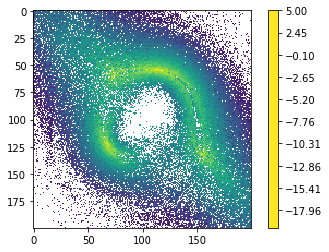

In [296]:
# "truth"-level (compared to truth image -- only really makes sense at zl \approx zd)
nfw_idx = 2 if zl < zd else 1 # index of first nfw lens (todo: check this)
almost_truth_args = [rsang, alphars]+[kwargs_lens[nfw_idx+i]['center_x'] for i in range(N)]+[kwargs_lens[nfw_idx+i]['center_y'] for i in range(N)]
print('almost truth args', almost_truth_args)
almost_truth_img = args_to_img(almost_truth_args)
print('almost truth error', error(almost_truth_img, image))
plt.imshow(np.log(abs(almost_truth_img - image))); plt.colorbar(boundaries=boundaries); plt.show()

In certain cases, the error is dominated by a single pixel, and this makes the total error pretty bad. Let's try an error function that ignores the very center? (This is pixel number 20100, if we flatten the image (and assume it's a 200x200 image).)

## Correlations

Note that the following graphs may (or may not) include points from during the burn-in period! To make a graph we can trust, you should only include points from after when the MCMC started to converge.

In [ ]:
plt.loglog(sampler.chain[:,:,0].flatten(), sampler.chain[:,:,1].flatten(), 'o', alpha=.01)
plt.xlabel('rsang')
plt.ylabel('alphars')

**TODO** : get the graph above in terms of mass!

In [ ]:
plt.scatter(sampler.chain[:,:,2].flatten(), sampler.chain[:,:,3].flatten(), alpha=.05, color='blue', label='First NFW position')
plt.scatter(sampler.chain[:,:,4].flatten(), sampler.chain[:,:,5].flatten(), alpha=.05, color='red', label='Second NFW position')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
plt.scatter(sampler.chain[:,:,4].flatten(), sampler.chain[:,:,5].flatten(), alpha=.05, color='red', label='Second NFW position')
plt.scatter(sampler.chain[:,:,2].flatten(), sampler.chain[:,:,3].flatten(), alpha=.05, color='blue', label='First NFW position')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Does this distinction imply that we're in just one of multiple local minima? I think so. (But why am I even making commentary when I know I'm going to change parameters and make a different-looking graph?)

In [ ]:
plt.scatter(sampler.chain[:,:,2].flatten() - sampler.chain[:,:,4].flatten(),
            sampler.chain[:,:,3].flatten() - sampler.chain[:,:,5].flatten(),
            alpha=.05)

plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$\Delta y$')
plt.show()

# Conclusions
* For `N=2`, in front of the lens (`j=10`), where we put the interlopers at 0.1 Einstein radius, we got two well-separated clusters, and we were bumping up against the `alphars < 0.1` limit. The solutions didn't intermix even though I see no reason why they shouldn't. (Is `emcee` purposefully breaking the symmetry under the hood? I don't think so.)
* For `N=2`, at the lens (`j=19`), where we put the interlopers at 0.1 Einstein radius, we got two partially overlapping clusters, not bumping up against any particular limit. The error is much lower if we ignore the central pixel (position 20100) -- goes from about $75^2$ to about $2$.